In [77]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# API 
from api import FED_API
import requests

# Machine learning libraries
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Technical indicator library
#import talib as ta

# Data import library
import yfinance as yf

#Data visualisation
import plotly.graph_objs as go
import matplotlib.pyplot as plt

#Data Source
import tradingeconomics as te

In [78]:
# Gather last 22yrs of data
SPY = yf.download('SPY', period = '50y', interval = '1wk')
NSD = yf.download('SPY', period = '50y', interval = '1wk')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [79]:
# Data does not go back far enough
SPY.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-25,43.96875,43.96875,43.75000,43.93750,25.627359,1003200.0
1993-02-01,43.96875,45.09375,43.96875,44.96875,26.228853,2234800.0
1993-02-08,44.96875,45.12500,44.53125,44.59375,26.010122,1159800.0
1993-02-15,44.46875,44.46875,42.81250,43.56250,25.408615,998700.0
1993-02-22,43.68750,44.43750,43.46875,44.40625,25.900763,1024300.0


In [80]:
# temp login to tradingeconomics
te.login()

'You are logged in as a guest:guest'

In [81]:
#check what indicators are avialable with Trading Economics API
te.getIndicatorData(output_type='df')

Without country indication only a list of available indicators will be returned...


,Category,CategoryGroup
0,ADP Employment Change,Labour
1,ANZ Roy Morgan Consumer Confidence Index,Consumer
2,API Crude Imports,Business
3,API Crude Oil Stock Change,Business
4,API Crude Runs,Business
5,API Cushing Number,Business
6,API Distillate Stocks,Business
7,API Gasoline Stocks,Business
8,API Heating Oil,Business
9,API Product Imports,Business


In [82]:
te.getIndicatorData(country='united states', output_type='df')

,Country,Category,Title,LatestValue,LatestValueDate,Source,Unit,URL,CategoryGroup,Adjustment,Frequency,HistoricalDataSymbol,CreateDate,PreviousValue,PreviousValueDate
0,United States,ADP Employment Change,United States ADP Employment Change,-301.00,2022-01-31T00:00:00,"Automatic Data Processing, Inc.",Thousand,/united-states/adp-employment-change,Labour,SA,Monthly,UNITEDSTAADPEMPCHA,2014-04-30T13:57:00,776.00,2021-12-31T00:00:00
1,United States,API Crude Imports,United States API Crude Imports,-0.05,2022-02-04T00:00:00,American Petroleum Institute (API),BBL/1Million,/united-states/api-crude-imports,Business,,Weekly,UNITEDSTAAPICRUIMP,2020-07-20T10:54:00,0.59,2022-01-28T00:00:00
2,United States,API Crude Oil Stock Change,United States API Crude Oil Stock Change,-2.03,2022-02-04T00:00:00,American Petroleum Institute (API),BBL/1Million,/united-states/api-crude-oil-stock-change,Business,,Weekly,APICRUDEOIL,2017-11-28T15:21:00,-1.65,2022-01-28T00:00:00
3,United States,API Crude Runs,United States API Crude Runs,0.18,2022-02-04T00:00:00,American Petroleum Institute (API),BBL/1Million,/united-states/api-crude-runs,Business,,Weekly,UNITEDSTAAPICRURUN,2020-07-20T11:02:00,-0.09,2022-01-28T00:00:00
4,United States,API Cushing Number,United States API Cushing Number,-2.50,2022-02-04T00:00:00,American Petroleum Institute (API),BBL/1Million,/united-states/api-cushing-number,Business,,Weekly,UNITEDSTAAPICUSNUM,2020-07-20T11:07:00,-1.03,2022-01-28T00:00:00
5,United States,API Distillate Stocks,United States API Distillate Stocks,-2.20,2022-02-04T00:00:00,American Petroleum Institute (API),BBL/1Million,/united-states/api-distillate-stocks,Business,,Weekly,UNITEDSTAAPIDISSTO,2020-07-20T11:09:00,-2.51,2022-01-28T00:00:00
6,United States,API Gasoline Stocks,United States API Gasoline Stocks,-1.14,2022-02-04T00:00:00,American Petroleum Institute (API),BBL/1Million,/united-states/api-gasoline-stocks,Business,,Weekly,UNITEDSTAAPIGASSTO,2020-07-20T11:11:00,5.82,2022-01-28T00:00:00
7,United States,API Heating Oil,United States API Heating Oil,0.59,2022-02-04T00:00:00,American Petroleum Institute (API),BBL/1Million,/united-states/api-heating-oil,Business,,Weekly,UNITEDSTAAPIHEAOIL,2020-07-20T11:12:00,-0.35,2022-01-28T00:00:00
8,United States,API Product Imports,United States API Product Imports,0.06,2022-02-04T00:00:00,American Petroleum Institute (API),BBL/1Million,/united-states/api-product-imports,Business,,Weekly,UNITEDSTAAPIPROIMP,2020-07-20T11:14:00,0.04,2022-01-28T00:00:00
9,United States,Asylum Applications,United States Asylum Applications,191367.00,2020-12-31T00:00:00,US Department of Justice,Persons,/united-states/asylum-applications,Government,NSA,Yearly,UNITEDSTAASYAPP,2015-09-10T15:49:00,214249.00,2019-12-31T00:00:00


#### Finding: Not going to help

#### FED Info

In [83]:
# test connection
base_url = "https://api.stlouisfed.org/fred/series?series_id=fedfunds&api_key="+FED_API+"&file_type=json"
fed_data = requests.get(base_url).json()

In [84]:
fed_data

{'realtime_start': '2022-02-10',
 'realtime_end': '2022-02-10',
 'seriess': [{'id': 'FEDFUNDS',
   'realtime_start': '2022-02-10',
   'realtime_end': '2022-02-10',
   'title': 'Federal Funds Effective Rate',
   'observation_start': '1954-07-01',
   'observation_end': '2022-01-01',
   'frequency': 'Monthly',
   'frequency_short': 'M',
   'units': 'Percent',
   'units_short': '%',
   'seasonal_adjustment': 'Not Seasonally Adjusted',
   'seasonal_adjustment_short': 'NSA',
   'last_updated': '2022-02-01 15:19:02-06',
   'popularity': 96,
   'notes': 'Averages of daily figures.  \r\n\r\nFor additional historical federal funds rate data, please see  Daily Federal Funds Rate from 1928-1954 (https://fred.stlouisfed.org/categories/33951).\r\n\r\nThe federal funds rate is the interest rate at which depository institutions trade federal funds (balances held at Federal Reserve Banks) with each other overnight. When a depository institution has surplus balances in its reserve account, it lends to o

In [85]:
#&realtime_start=1975-01-01
# test connection
base_url = "https://api.stlouisfed.org/fred/series/observations?series_id=fedfunds&realtime_start=1975-01-01&api_key="+FED_API+"&file_type=json"
fed_rate = requests.get(base_url).json()

In [86]:
# check keys
fed_rate.keys()

dict_keys(['realtime_start', 'realtime_end', 'observation_start', 'observation_end', 'units', 'output_type', 'file_type', 'order_by', 'sort_order', 'count', 'offset', 'limit', 'observations'])

In [87]:
# check to see if this pulls needed observations
fed_rate['observations'][-1]

{'realtime_start': '2022-02-01',
 'realtime_end': '9999-12-31',
 'date': '2022-01-01',
 'value': '0.08'}

In [113]:
# transform dictionary data from specific key to panda df
df = pd.DataFrame(fed_rate['observations'])

In [116]:
# check 
df.tail()

,date,value
860,2021-09-01,0.08
861,2021-10-01,0.08
862,2021-11-01,0.08
863,2021-12-01,0.08
864,2022-01-01,0.08


In [117]:
# drop ..start ...end columns
df = df.drop(['realtime_start', 'realtime_end'],axis=1)

KeyError: "['realtime_start' 'realtime_end'] not found in axis"

In [127]:
# set df index to date and rename column
df = df.set_index('date')
df = df.rename(columns={'value':'Fed_Funds_effective'})

In [128]:
df

,Fed_Funds_effective
date,
1954-07-01,0.80
1954-08-01,1.22
1954-09-01,1.06
1954-09-01,1.07
1954-09-01,1.06
...,...
2021-09-01,0.08
2021-10-01,0.08
2021-11-01,0.08


In [139]:
#convert index to datetime
df.index = pd.to_datetime(df.index)
df

,Fed_Funds_effective
date,
1954-07-01,0.80
1954-08-01,1.22
1954-09-01,1.06
1954-09-01,1.07
1954-09-01,1.06
...,...
2021-09-01,0.08
2021-10-01,0.08
2021-11-01,0.08


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 865 entries, 1954-07-01 to 2022-01-01
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Fed_Funds_effective  865 non-null    object
dtypes: object(1)
memory usage: 13.5+ KB


#### NOTE: This is not the FED FUNDS rate but the effective rate

In [131]:
base_url2 = "https://api.stlouisfed.org/fred/series/id&api_key="+FED_API+"&file_type=json"

In [132]:
seek = requests.get(base_url2)

In [133]:
seek

<Response [500]>

In [134]:
# let's try and just get Fed Funds

In [135]:
#&realtime_start=1975-01-01
# test connection
base_url3 = "https://api.stlouisfed.org/fred/series/observations?series_id=fedfunds&realtime_start=1975-01-01&api_key="+FED_API+"&file_type=json"
fed_rate3 = requests.get(base_url3).json()

In [136]:
# check to see if this pulls needed observations
fed_rate3['observations'][-1]

{'realtime_start': '2022-02-01',
 'realtime_end': '9999-12-31',
 'date': '2022-01-01',
 'value': '0.08'}

In [153]:
df.describe()

,Fed_Funds_effective
count,865
unique,502
top,0.09
freq,20


In [161]:
len(df.index.unique())

811

#### NOTE: total count of observations =! total index.unique -> some dates are duplicated

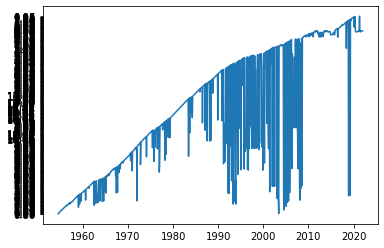

In [147]:
plt.plot(df.index, df.Fed_Funds_effective)
plt.show()

In [148]:
df.index

DatetimeIndex(['1954-07-01', '1954-08-01', '1954-09-01', '1954-09-01',
               '1954-09-01', '1954-09-01', '1954-10-01', '1954-11-01',
               '1954-12-01', '1955-01-01',
               ...
               '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
               '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
               '2021-12-01', '2022-01-01'],
              dtype='datetime64[ns]', name='date', length=865, freq=None)